In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as trans
import utils
import argparse
from scipy.fftpack import dct, idct
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/private/home/chuanguo/.conda/envs/pytorch_1.7.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [2]:
def zero_low_frequencies(x, ratio=0.5):
    assert x.size(1) == x.size(2)
    image_size = x.size(1)
    mask = np.zeros(x.size())
    mask[:, :int(image_size * ratio), :int(image_size * ratio)] = 1
    x_dct = dct(dct(x.numpy(), axis=1, norm="ortho"), axis=2, norm="ortho")
    x_dct *= mask
    x = torch.from_numpy(idct(idct(x_dct, axis=2, norm='ortho'), axis=1, norm='ortho'))
    return x

def low_freq_pgd(model, X, target, dct_ratio=1.0, epsilon=0.03, step_size=0.01, num_steps=20):
    X = X.cuda()
    pert = torch.zeros_like(X)
    pert.requires_grad = True
    target = torch.LongTensor([target]).cuda()
    for _ in range(num_steps):
        pred = model(utils.apply_normalization((X + pert).unsqueeze(0), 'imagenet'))
        loss = torch.nn.functional.cross_entropy(pred, target)
        print(loss)
        loss.backward()
        grad = pert.grad
        if dct_ratio < 1.0:
            grad = zero_low_frequencies(grad.cpu(), dct_ratio).cuda()
        with torch.no_grad():
            pert -= step_size * grad.sign()
            pert.clamp_(-epsilon, epsilon)
            X_pert = (X + pert).clamp(0, 1)
            pert.data = X_pert - X
    return (X + pert).detach()


In [3]:
parser = argparse.ArgumentParser(description='Runs PGD attack in LF-DCT space')
parser.add_argument('--data_root', type=str, required=True, help='root directory of imagenet data')
parser.add_argument('--num_steps', type=int, default=20, help='maximum number of iterations')
parser.add_argument('--dct_ratio', type=float, default=0.125, help='ratio of nonzero frequencies for dct')
args = parser.parse_args("")


tensor(1.7449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1406, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=

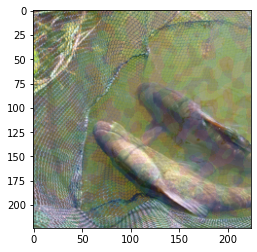

In [4]:
model = models.resnet50(pretrained=True).cuda()
model.eval()

testset = datasets.ImageFolder(args.data_root + '/val', utils.IMAGENET_TRANSFORM)
X, y = testset[0]
Z = low_freq_pgd(model, X, y, dct_ratio=args.dct_ratio)
plt.imshow(np.rollaxis(Z.cpu().numpy(), 0, 3))